In [2]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 2.0 MB/s eta 0:00:01


In [158]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms

In [155]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2

In [5]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 

In [8]:
df = pd.read_csv('face_pic.csv')
df.head()

image_file        label dataset  \
0   2734.png  WithoutMask    Test   
1   4345.png  WithoutMask    Test   
2   4423.png  WithoutMask    Test   
3   2052.png  WithoutMask    Test   
4   3364.png  WithoutMask    Test   

                                          image_path  
0  ../data/sourse2/Face_Mask_Dataset/Test/Without...  
1  ../data/sourse2/Face_Mask_Dataset/Test/Without...  
2  ../data/sourse2/Face_Mask_Dataset/Test/Without...  
3  ../data/sourse2/Face_Mask_Dataset/Test/Without...  
4  ../data/sourse2/Face_Mask_Dataset/Test/Without...

# Image Face Detection

torch.Size([3, 160, 160])

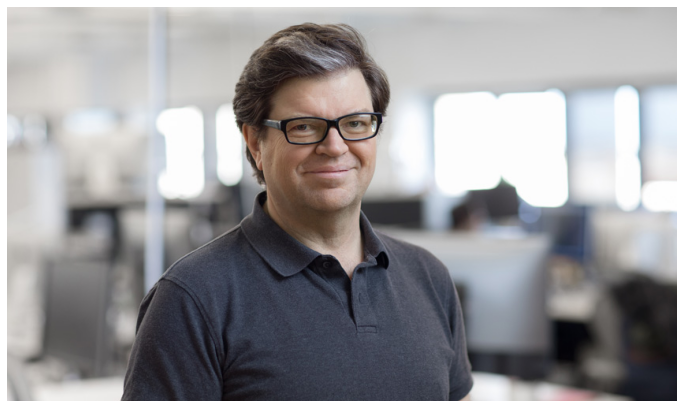

In [31]:
# Create face detector
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False
)

# Load a single image and display
# v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/agqphdxmwt.mp4')
# success, frame = v_cap.read()
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# frame = Image.fromarray(frame)

# row = df.iloc[1000]
# image_path = row['image_path']
# fname = row['image_file']
# path = image_path+'/'+fname
path = 'yann.jpg'
img = cv2.imread(path)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

plt.figure(figsize=(12, 8))
plt.imshow(out_img)
plt.axis('off')

# Detect face
face = mtcnn(out_img)
face.shape

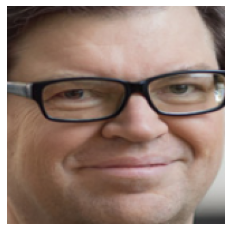

In [32]:
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');

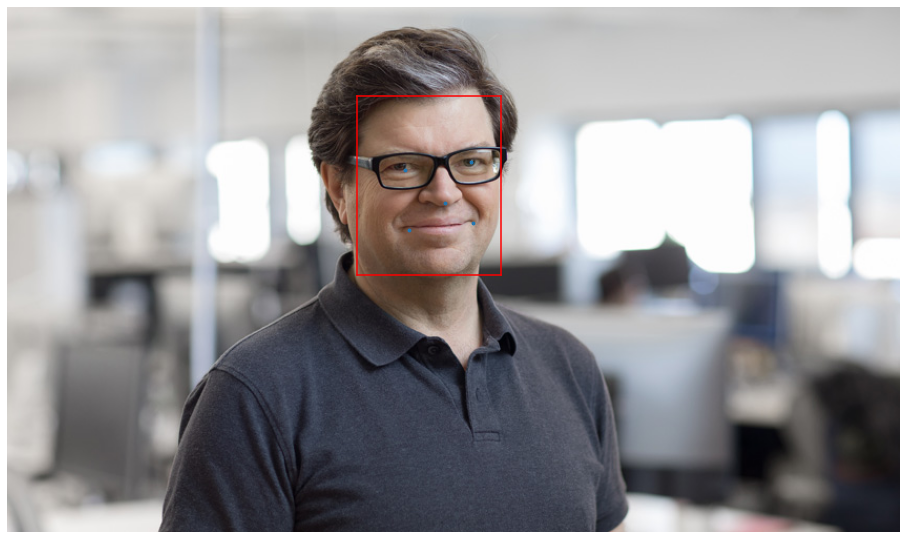

In [81]:
boxes, probs, landmarks = mtcnn.detect(out_img, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(out_img)
ax.axis('off')

def draw_boxes(box):
    ax.plot([box[0],box[2]],[box[1],box[1]],color = 'r')
    ax.plot([box[0],box[2]],[box[3],box[3]],color = 'r')
    ax.plot([box[0],box[0]],[box[1],box[3]],color = 'r')
    ax.plot([box[2],box[2]],[box[1],box[3]],color = 'r')    
    
for box, landmark in zip(boxes, landmarks):
    draw_boxes(box)
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)

In [71]:
np.meshgrid(box[[0, 2]], box[[1, 3]])

[array([[332.4167, 469.8135],
        [332.4167, 469.8135]], dtype=float32),
 array([[ 84.406235,  84.406235],
        [254.65602 , 254.65602 ]], dtype=float32)]

In [72]:
box[[0, 2]], box[[1, 3]]

(array([332.4167, 469.8135], dtype=float32),
 array([ 84.406235, 254.65602 ], dtype=float32))

In [73]:
np.meshgrid(box[[0, 2]], box[[1, 3]])

[array([[332.4167, 469.8135],
        [332.4167, 469.8135]], dtype=float32),
 array([[ 84.406235,  84.406235],
        [254.65602 , 254.65602 ]], dtype=float32)]

# Combine with mask detection

In [84]:
model = torch.load('MobileNetV2_mask')
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [146]:
face_resized = cv2.resize(np.array(face.permute(1, 2, 0)), (256, 256))

In [147]:
transform = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
transformed = transform(image=face_resized.astype(np.uint8))

In [148]:
transformed = transformed['image']

In [151]:
transformed.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [162]:
model(transformed.unsqueeze(0))

tensor([[ 2.9262, -2.4894]], grad_fn=<AddmmBackward>)

In [172]:
softmax = nn.Softmax(dim = 1)
y_pred = model(transformed.unsqueeze(0))
prob = max(softmax(y_pred)[0])
y_pred = torch.argmax(y_pred, dim=1)
print(y_pred,prob)

tensor([0]) tensor(0.9956, grad_fn=<UnbindBackward>)


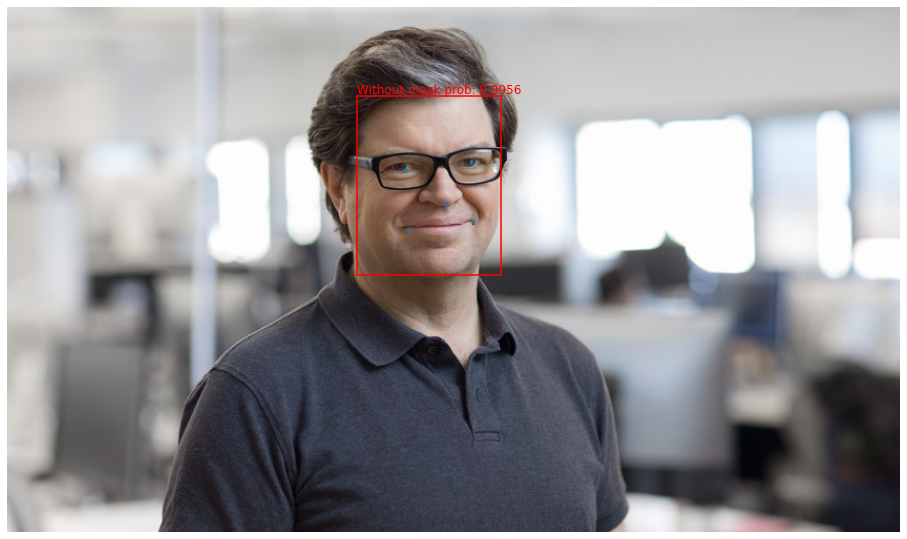

In [193]:
if y_pred:
    out = 'With mask'
    color = 'g'
else:
    out = 'Without mask'
    color = 'r'
    
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(out_img)
ax.axis('off')

def draw_boxes(box):
    ax.text(box[0], box[1]-2, out+f' prob: {prob:.4f}', fontsize=12,color = color)
    ax.plot([box[0],box[2]],[box[1],box[1]],color = color)
    ax.plot([box[0],box[2]],[box[3],box[3]],color = color)
    ax.plot([box[0],box[0]],[box[1],box[3]],color = color)
    ax.plot([box[2],box[2]],[box[1],box[3]],color = color)    
    
for box, landmark in zip(boxes, landmarks):
    draw_boxes(box)
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)

In [181]:
[box[0],box[2]],[box[1],box[1]]

([332.4167, 469.8135], [84.406235, 84.406235])

# Multiple people

In [268]:
path = 'maksssksksss99.png'

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    keep_all = True
)

img = cv2.imread(path)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

# Detect face
face = mtcnn(out_img)

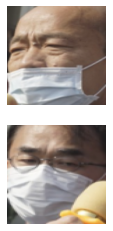

In [270]:
fig, axs = plt.subplots(face.shape[0])
if face.shape[0] == 1:
    axs.imshow(face[0].permute(1, 2, 0).int().numpy())
    axs.axis('off');
else:
    for i,item in enumerate(face):
        axs[i].imshow(item.permute(1, 2, 0).int().numpy())
        axs[i].axis('off');

In [271]:
transform = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
pred_list = []
prob_list = []
for item in face:
    
    face_resized = cv2.resize(np.array(item.permute(1, 2, 0)), (256, 256))

    transformed = transform(image=face_resized.astype(np.uint8))
    transformed = transformed['image']
    softmax = nn.Softmax(dim = 1)
    y_pred = model(transformed.unsqueeze(0))
    prob = max(softmax(y_pred)[0])
    y_pred = torch.argmax(y_pred, dim=1)
    pred_list.append(y_pred)
    prob_list.append(prob)
    print(y_pred,prob)

tensor([0]) tensor(0.5723, grad_fn=<UnbindBackward>)
tensor([1]) tensor(0.9993, grad_fn=<UnbindBackward>)


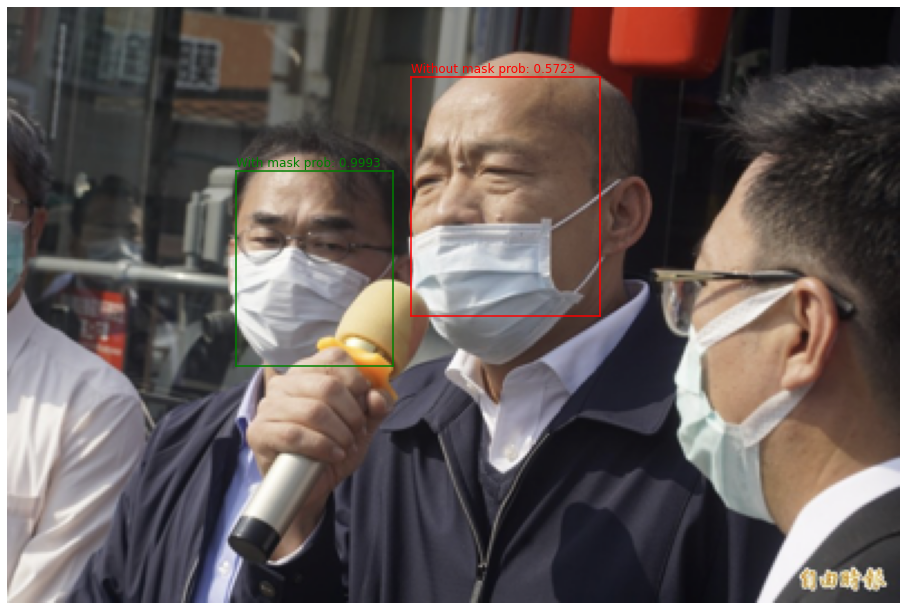

In [272]:


# Visialization
boxes, probs, landmarks = mtcnn.detect(out_img, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(out_img)
ax.axis('off')

def draw_boxes(box):
    ax.text(box[0], box[1]-2, out+f' prob: {prob:.4f}', fontsize=12,color = color)
    ax.plot([box[0],box[2]],[box[1],box[1]],color = color)
    ax.plot([box[0],box[2]],[box[3],box[3]],color = color)
    ax.plot([box[0],box[0]],[box[1],box[3]],color = color)
    ax.plot([box[2],box[2]],[box[1],box[3]],color = color)    

i = 0
for box, landmark in zip(boxes, landmarks):
    y_pred = pred_list[i]
    prob = prob_list[i]
    if y_pred:
        out = 'With mask'
        color = 'g'
    else:
        out = 'Without mask'
        color = 'r'
    draw_boxes(box)
    i+=1
    #ax.scatter(landmark[:, 0], landmark[:, 1], s=8)

# Pipeline Design

In [292]:
def read_img(path):
    '''
    read image file
    '''
    img = cv2.imread(path)
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    return out_img

def detect_face(out_img):
    '''
    return all faces picture in image
    '''
    face = mtcnn(out_img)
    return face

def faces_classification(face):
    '''
    input a batch of face image fensor, return list of classification results
    '''
    pred_list = []
    prob_list = []
    for item in face:

        face_resized = cv2.resize(np.array(item.permute(1, 2, 0)), (256, 256))

        transformed = transform(image=face_resized.astype(np.uint8))
        transformed = transformed['image']
        softmax = nn.Softmax(dim = 1)
        y_pred = model(transformed.unsqueeze(0))
        prob = max(softmax(y_pred)[0])
        y_pred = torch.argmax(y_pred, dim=1)
        pred_list.append(y_pred)
        prob_list.append(prob)
    return pred_list,prob_list


            
def draw_boxes(ax,box,out,prob,color):
    ax.text(box[0], box[1]-2, out+f' prob: {prob:.4f}', fontsize=12,color = color)
    ax.plot([box[0],box[2]],[box[1],box[1]],color = color)
    ax.plot([box[0],box[2]],[box[3],box[3]],color = color)
    ax.plot([box[0],box[0]],[box[1],box[3]],color = color)
    ax.plot([box[2],box[2]],[box[1],box[3]],color = color)   
            
def face_detection(out_img):
    face = detect_face(out_img)
    pred_list,prob_list = faces_classification(face)
    
    # Visialization
    boxes, probs, landmarks = mtcnn.detect(out_img, landmarks=True)
    # Visualize
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(out_img)
    ax.axis('off')
    
    i = 0
    for box, landmark in zip(boxes, landmarks):
        y_pred = pred_list[i]
        prob = prob_list[i]
        if y_pred:
            out = 'With mask'
            color = 'g'
        else:
            out = 'Without mask'
            color = 'r'
        draw_boxes(ax,box,out,prob,color)
        i+=1
        #ax.scatter(landmark[:, 0], landmark[:, 1], s=8)

def face_subplots(out_img):
    '''
    input a batch of face image fensor, plot faces
    '''
    face = detect_face(out_img)
    fig, axs = plt.subplots(face.shape[0])
    if face.shape[0] == 1:
        axs.imshow(face[0].permute(1, 2, 0).int().numpy())
        axs.axis('off');
    else:
        for i,item in enumerate(face):
            axs[i].imshow(item.permute(1, 2, 0).int().numpy())
            axs[i].axis('off');

### Test

In [293]:
path = 'maksssksksss99.png'

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    keep_all = True
)

transform = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                # convert to a tensor and move color channels
                ToTensorV2()
            ])

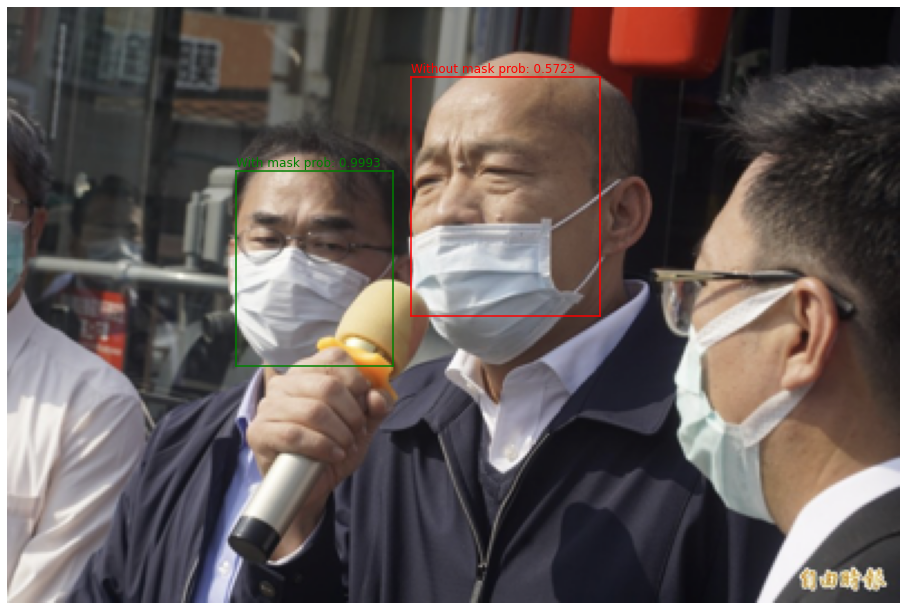

In [294]:
out_img = read_img(path)
face_detection(out_img)

In [298]:
all_path = '../data/sourse1/images'
all_file = [all_path +'/'+ x for x in os.listdir(all_path)]

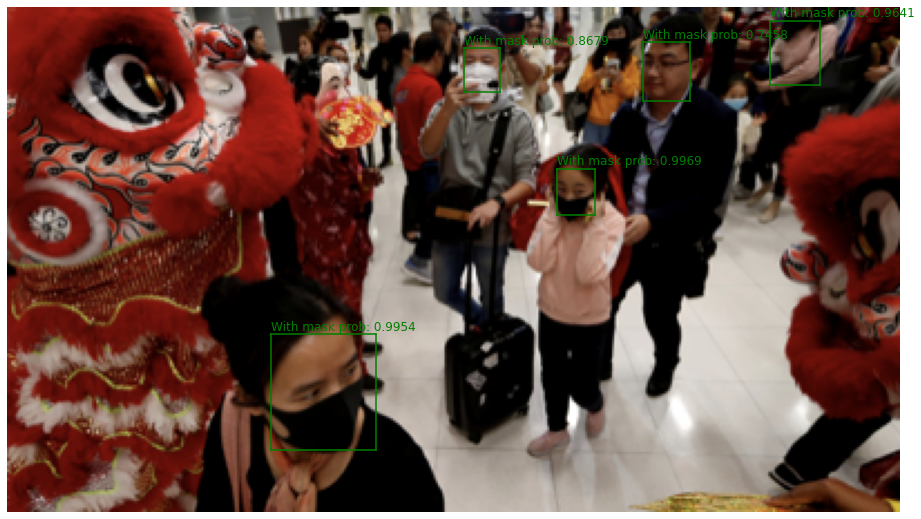

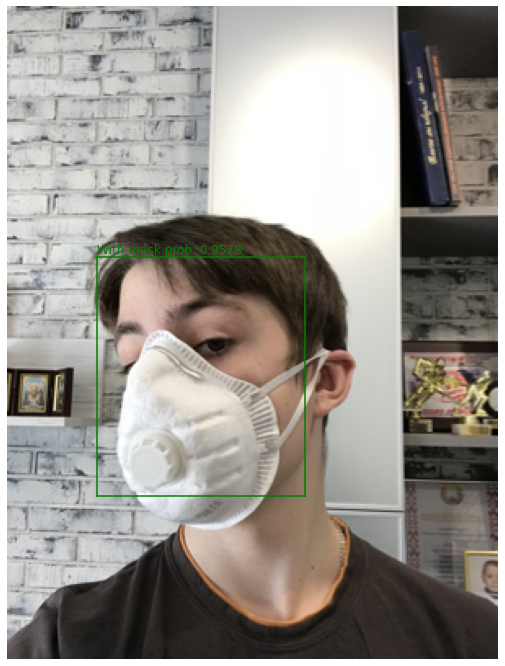

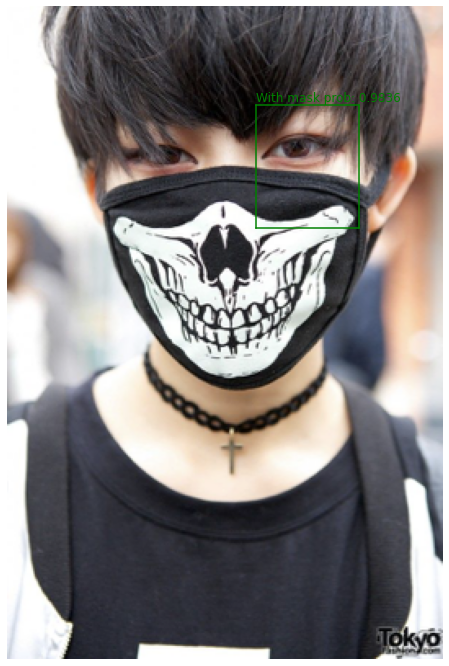

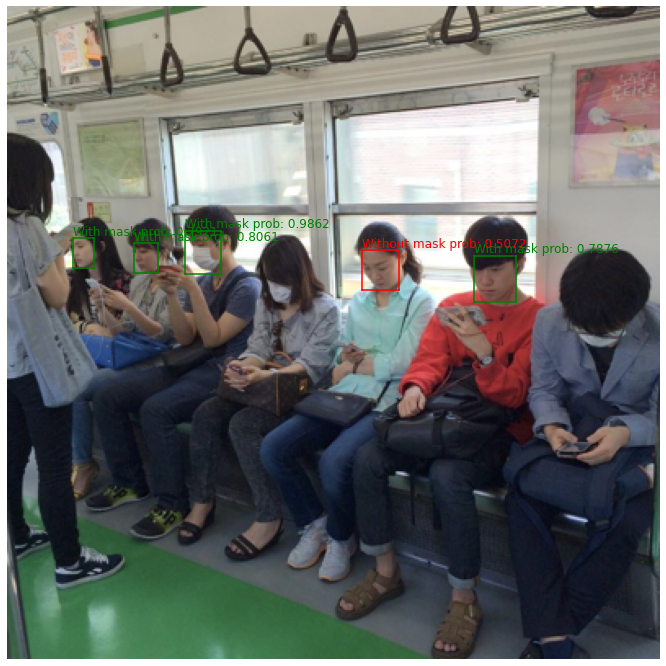

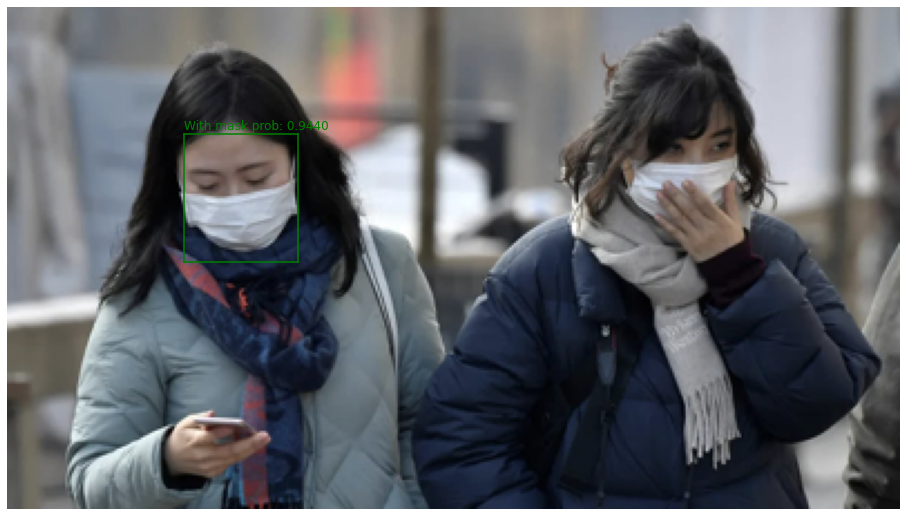

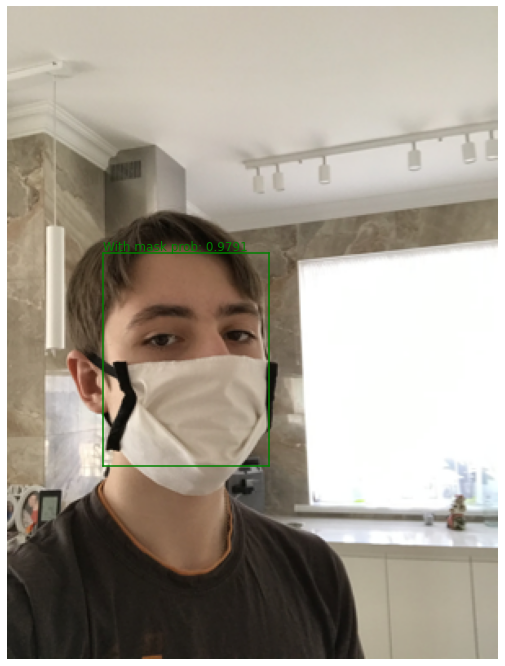

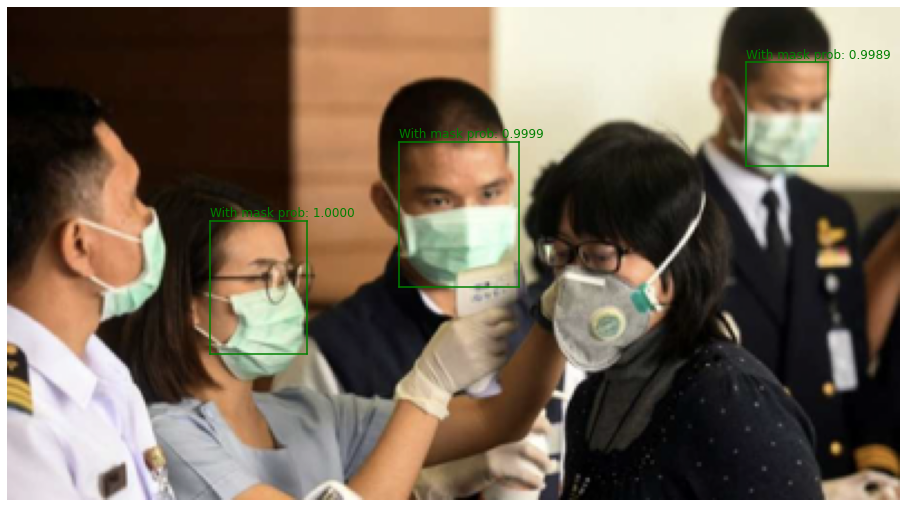

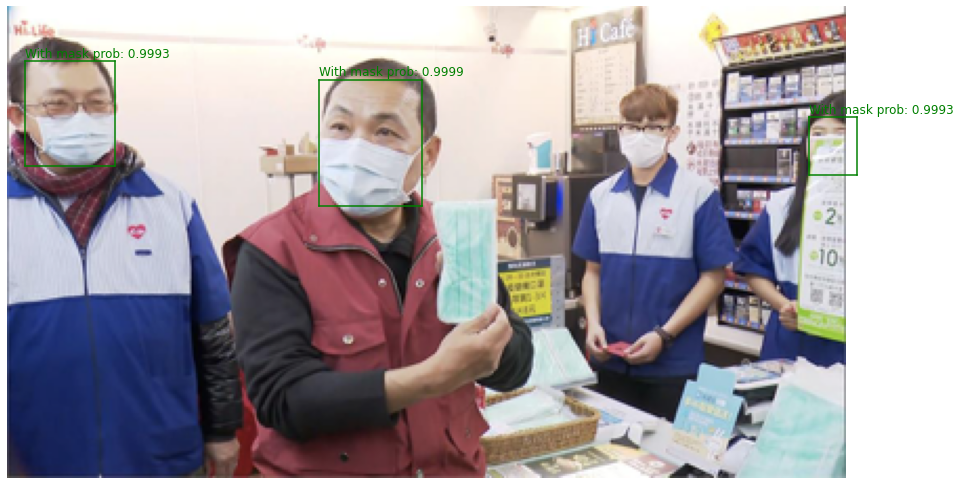

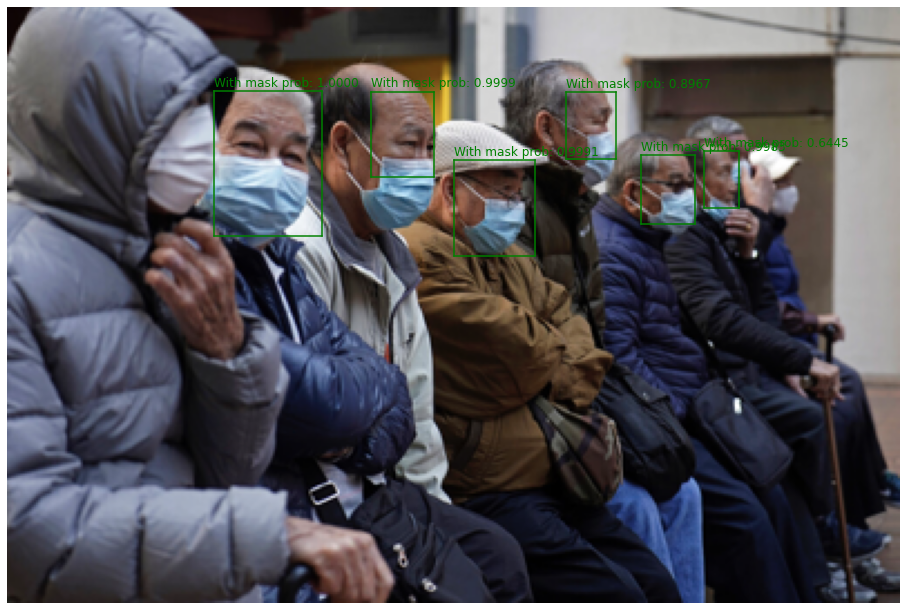

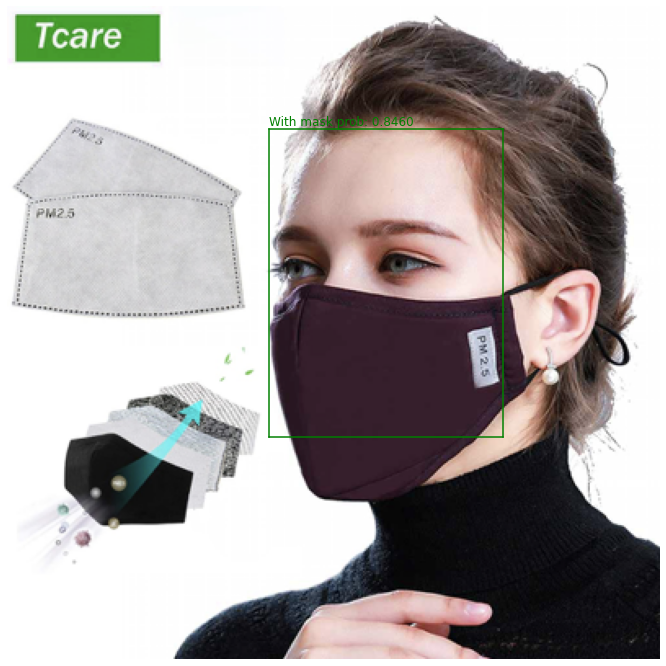

In [303]:
import random

num_selections = 10

new_list = random.sample(all_file, num_selections)

for item in new_list:
    try:
        out_img = read_img(item)
        face_detection(out_img)
    except:
        print('Can not open image')
        continue

# Referrences

* https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch
* https://github.com/timesler/facenet-pytorch

In [310]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    face = faceNet(frame)
    pred_list,prob_list = faces_classification(face)
    boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    return boxes,pred_list,prob_list

In [311]:
detect_and_predict_mask(out_img,mtcnn,model)

(array([[160.07999,  74.49961, 303.37997, 263.3871 ]], dtype=float32),
 [tensor([1])],
 [tensor(0.8460, grad_fn=<UnbindBackward>)])